# Gaussian fit in aare with built in lmfit 

To run this example use the branch **lmfit**

In [1]:
#add the dev version of aare
import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import seaborn as sns
import time

#Directly import what we need from aare
from aare import CtbRawFile, fit_gaus, gaus, fit_pol1, pol1
from aare.transform import moench05

Example run on: **2025-02-12 09:35** with aare: **dev**

## API usage

In [2]:
#Create some sample data
n_samples = 1000
mu = 7
sigma = 1.3
values = np.random.normal(loc = mu, scale = sigma, size = n_samples)
hist = bh.Histogram(bh.axis.Regular(60, 0, 14))
hist.fill(values)
x = hist.axes[0].edges[:-1]
x = hist.axes.centers[0]
y = hist.values()

### Without errors

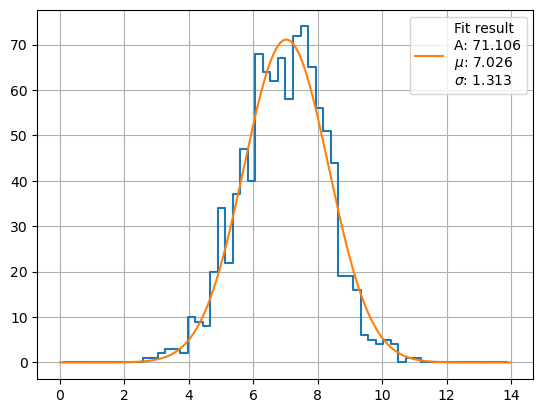

In [3]:
#Do the actual fitting
par = fit_gaus(x,y)

#Use the gaus function from aare to evaluate the 
#result in small steps
xx = np.linspace(0,14,1000)
yy = gaus(xx, par)

#Plot results
fig, ax = plt.subplots()
ax.step(x, y, where="mid");
label = fr"""Fit result
A: {par[0]:.3f}
$\mu$: {par[1]:.3f}
$\sigma$: {par[2]:.3f}"""
ax.plot(xx,yy, label = label)
ax.legend()
ax.grid();

### With errors

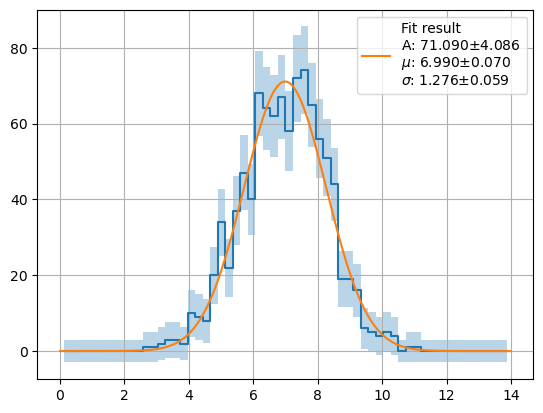

In [4]:
#Estimate errors as square root of the number of samples
#in a single bin. Add 1 to avoid 0s in the error estimate
#Lower errors generally narrows the fit. 
y_err = np.sqrt(y)+3
par, err = fit_gaus(x,y, y_err)
xx = np.linspace(0,14,1000)
yy = gaus(xx, par)
fig, ax = plt.subplots()
ax.step(x, y, where="mid");

ax.fill_between(x, y-y_err, y+y_err, step = 'mid', alpha = 0.3)

label = fr"""Fit result
A: {par[0]:.3f}$\pm{err[0]:.3f}$
$\mu$: {par[1]:.3f}$\pm{err[1]:.3f}$
$\sigma$: {par[2]:.3f}$\pm{err[2]:.3f}$"""

ax.plot(xx,yy, label = label)
ax.legend()
ax.grid();

### pol1

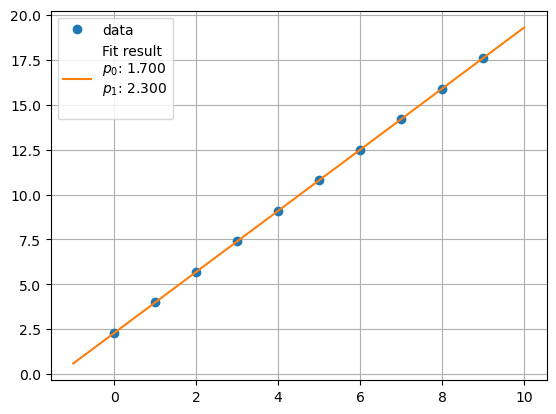

In [5]:
#Generate some data
x = np.arange(10, dtype = np.float64)
y = 2.3+1.7*x

par = fit_pol1(x,y)
xx = np.linspace(-1,10, 100)
yy = pol1(xx, par)

#plotting the fit
fig, ax = plt.subplots()
ax.plot(x,y, 'o', label = 'data')
label = fr"""Fit result
$p_0$: {par[0]:.3f}
$p_1$: {par[1]:.3f}
"""
ax.plot(xx,yy, label = label)
ax.legend()
ax.grid();


## Fill a 3D histogram with dark frames 

In [6]:

base = Path('/mnt/sls_det_storage/moench_data/Julian/MOENCH05/20250113_xrays_scan_energy/raw_files/')
cluster_file = Path('/home/l_msdetect/erik/tmp/Cu.clust')
pedestal_file = base/'moench05_noise_Cu_10_us_master_0.json'
data_file = base/'moench05_xray_Cu_10_us_master_0.json'

offset = -0.5
hist3d = bh.Histogram(
    bh.axis.Regular(160, 0+offset, 160+offset),  #x
    bh.axis.Regular(150, 0+offset, 150+offset),  #y
    bh.axis.Regular(50, 3000, 4000), #ADU
)

#Calculate indicies for a faster fill
#TODO! Is there a cleaner way to to this? 
rows = np.zeros(160*150)
cols = np.zeros(160*150)

for row in range(160):
    for col in range(150):
        rows[row*150+col] = row
        cols[row*150+col] = col

#Read data and fill histogram
with CtbRawFile(pedestal_file, transform=moench05) as f:
    for i in range(1000):
        frame_number, frame = f.read_frame()
        hist3d.fill(rows, cols, frame.flat)

data = hist3d.view()
x = hist3d.axes[2].centers

In [7]:
#by passing in a 3d array [row, col, values] we can fit all pixels in one go
t0 = time.perf_counter()
res = fit_gaus(x, data, n_threads = 8)
print(f'Fitting took: {time.perf_counter()-t0:.3f}s')

Fitting took: 0.087s


(0, 0) [ 171.60838561 3366.8909655    46.21291228]
(20, 7) [ 381.68589155 3521.96299635   21.11886354]
(100, 100) [ 355.86152524 3377.25821174   22.34016146]
(120, 130) [ 313.42839431 3103.50189362   25.60669728]


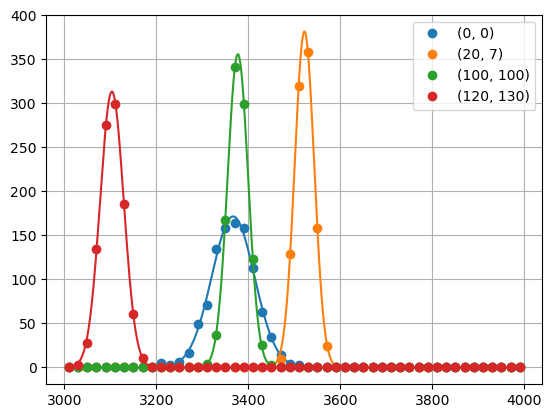

In [8]:
#Plot some "random" pixels
colors = sns.color_palette()
pixels = [(0,0), (20,7), (100,100), (120,130)]
xx = np.linspace(x[0], x[-1], 1000)

fig, ax = plt.subplots()
for i, pixel in enumerate(pixels):
    ax.plot(x, data[*pixel], 'o', color = colors[i], label = str(pixel))
    ax.plot(xx, gaus(xx, res[*pixel]), color = colors[i])
    print(pixel, res[*pixel])
ax.legend()
ax.grid()

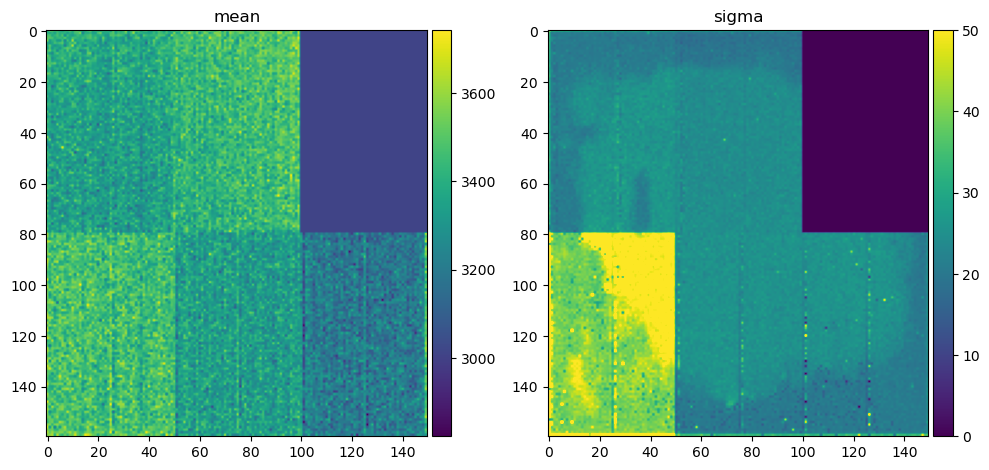

In [9]:
im = []
fig, axs = plt.subplots(1,2,figsize = (10,5))
im.append(axs[0].imshow(res[:,:,1]))
im.append(axs[1].imshow(res[:,:,2]))

axs[0].set_title('mean')
im[1].set_clim(0,50)
axs[1].set_title('sigma')
for i,ax in enumerate(axs):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im[i], cax=cax)
fig.tight_layout()

## Looping from python

In [10]:
t0 = time.perf_counter()
noise = np.zeros((160,150))
for row in range(160):
    for col in range(150):
        noise[row, col] = fit_gaus(x, data[row, col])[2]

print(f'Looping in python took: {time.perf_counter()-t0:.3f}s')

Looping in python took: 0.581s


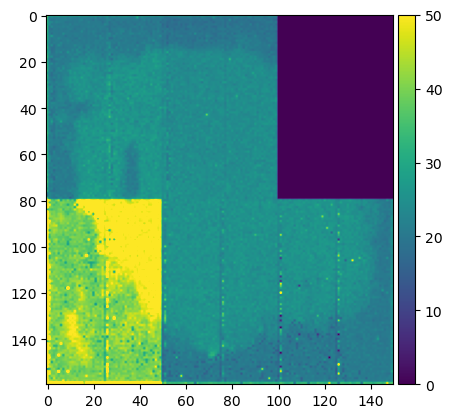

In [11]:
fig, ax = plt.subplots()
im = ax.imshow(res[:,:,2])
res.shape
im.set_clim(0,50)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

In [12]:
#sanity check, we get the same value when we loop in 
#python or loop in C++
if ((noise-res[:,:,2])==0).all():
    print('All pixels have the same value')
else:
    print('Something went wrong')


All pixels have the same value
